In [1]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
spam_data = pd.read_csv('spam.csv', encoding='ISO-8859-1', header=0)

In [3]:
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Part 1: Processing of textual data


## Displaying basic stats about the dataset:


In [4]:
# Basic stats about the dataframe
print(f"Number of rows : {spam_data.shape[0]}")
print()

print("Basic info: ")
spam_data.info()
print()

print("Display of spam_data: ")
display(spam_data.head())
print()

print("Basics statistics: ")
data_desc = spam_data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*spam_data.isnull().sum()/spam_data.shape[0]), columns=['% missing values']))

Number of rows : 5572

Basic info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB

Display of spam_data: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


,% missing values
v1,0.0
v2,0.0
Unnamed: 2,99.0
Unnamed: 3,100.0
Unnamed: 4,100.0


The Unnamed columns seem completely empty at first, however there do seem to be some not null columns

In [5]:
spam_data.loc[spam_data['Unnamed: 2'].notnull(), :]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [6]:
# Combining the columns v2, Unnamed: 2, Unnamed: 3, Unnamed: 4 into one column
spam_data['text'] = spam_data[['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].apply(lambda row: '\n'.join(str(item) for item in row if pd.notnull(item)), axis=1)

In [7]:
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,text
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*spam_data.isnull().sum()/spam_data.shape[0]), columns=['% missing values']))

Percentage of missing values: 


,% missing values
v1,0.0
v2,0.0
Unnamed: 2,99.0
Unnamed: 3,100.0
Unnamed: 4,100.0
text,0.0


Now we can drop the combined columns

In [9]:
spam_data.drop(['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam_data.rename(columns={'v1': 'label'}, inplace=True)

## Text cleaning:

In [10]:
nlp = spacy.load('en_core_web_md')

# Preprocess text
def preprocess_text(text):
    cleaned_text = text
    cleaned_text = ''.join(ch for ch in cleaned_text if ch.isalnum() or ch==" ")
    # Removing double spaces
    cleaned_text = cleaned_text.replace(" +"," ")
    doc = nlp(cleaned_text.strip())  # remove trailing and leading spaces
    lemmatized_text = " ".join([token.lemma_ for token in doc if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)])

    return lemmatized_text.lower()  # return lowercase lemmatized text


In [11]:
spam_data['text_cleaned'] = spam_data['text'].apply(preprocess_text)

In [12]:
spam_data.head()

,label,text,text_cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i think usf live


In [13]:
spam_data['label'] = spam_data['label'].replace({'ham': 0, 'spam': 1})

In [14]:
spam_data.head()

,label,text,text_cleaned
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i think usf live


## Tokenization of the cleaned data:

In [15]:
max_feature = 10000 #number of unique words to consider
tokenizer = Tokenizer(num_words=max_feature, oov_token='<OOV>')
tokenizer.fit_on_texts(spam_data['text_cleaned'])
spam_data['text_encoded'] = np.array(tokenizer.texts_to_sequences(spam_data['text_cleaned']), dtype=object)

In [16]:
spam_data.head()

,label,text,text_cleaned,text_encoded
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[3711, 235, 449, 464, 950, 36, 53, 206, 951, 8..."
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[11, 195, 3713, 287, 3, 1485]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 299, 4, 540, 671, 45, 1486, 859, 429, 148..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[3, 127, 152, 2423, 3, 86]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i think usf live,"[716, 2, 24, 672, 132]"


In [17]:
# Train Test Split
X_train, X_val, Y_train, Y_val = train_test_split(spam_data.text_encoded,spam_data.label, test_size=0.25, random_state=42, stratify=spam_data.label)

# Part 2: Text sequencing

## Padding the encoded texts:

In [18]:
X_train = pad_sequences(X_train.tolist())
X_val = pad_sequences(X_val.tolist())

In [19]:
X_train.shape, X_val.shape

((4179, 74), (1393, 74))

In [20]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

In [21]:
for t in train.take(1):
    print(t)

(<tf.Tensor: shape=(74,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2025,   84,  377, 1308, 2742,  487,
          2,  105,  377,  468,    6,   84,  113, 7794], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


## Building our batch training and validation datasets:

In [22]:
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)

# Part 3: Model building

Our model structure will be based on a Bi-directional LSTM.

## Model architecture:

In [23]:
vocab_size = tokenizer.num_words
#size of the output vector from each layer
embedding_vector_length = 128
#Creating a sequential model
model = tf.keras.Sequential()
#Creating an embedding layer to vectorize
model.add(Embedding(vocab_size+1, embedding_vector_length, name='embedding', input_length= X_train.shape[1]))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
#Relu allows converging quickly and allows backpropagation
model.add(Dense(16, activation='relu'))
#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))

## Compiling the model:

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 128)           1280128   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,381,025
Trainable params: 1,381,025
Non-trainable params: 0
______________________________________________

## Training the model:

In [25]:
history = model.fit(train_batch, 
                    epochs=30, 
                     validation_data=val_batch)

Epoch 1/30


2023-07-13 10:52:19.617477: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 4s 256ms/step - loss: 0.6176 - accuracy: 0.8579 - val_loss: 0.4397 - val_accuracy: 0.8658
Epoch 2/30
9/9 [==============================] - 2s 245ms/step - loss: 0.3912 - accuracy: 0.8660 - val_loss: 0.3612 - val_accuracy: 0.8658
Epoch 3/30
9/9 [==============================] - 2s 238ms/step - loss: 0.3291 - accuracy: 0.8660 - val_loss: 0.2670 - val_accuracy: 0.8658
Epoch 4/30
9/9 [==============================] - 2s 219ms/step - loss: 0.2234 - accuracy: 0.8861 - val_loss: 0.1826 - val_accuracy: 0.9476
Epoch 5/30
9/9 [==============================] - 2s 221ms/step - loss: 0.1414 - accuracy: 0.9670 - val_loss: 0.1272 - val_accuracy: 0.9720
Epoch 6/30
9/9 [==============================] - 2s 219ms/step - loss: 0.0891 - accuracy: 0.9856 - val_loss: 0.0918 - val_accuracy: 0.9770
Epoch 7/30
9/9 [==============================] - 2s 225ms/step - loss: 0.0504 - accuracy: 0.9916 - val_loss: 0.0622 - val_accuracy: 0.9828
Epoch 8/30
9/9 [===============

## Performance evaluation:

In [26]:
X_val

array([[   0,    0,    0, ...,    0,   56,  684],
       [   0,    0,    0, ..., 6329,  359, 6330],
       [   0,    0,    0, ...,  184,  315,   89],
       ...,
       [   0,    0,    0, ...,    4,   51, 2501],
       [   0,    0,    0, ...,   58,   19,   41],
       [   0,    0,    0, ...,  115, 4981, 4982]], dtype=int32)

In [27]:
Y_predict = [1 if o>0.5 else 0 for o in model.predict(X_val)]

44/44 [==============================] - 1s 8ms/step


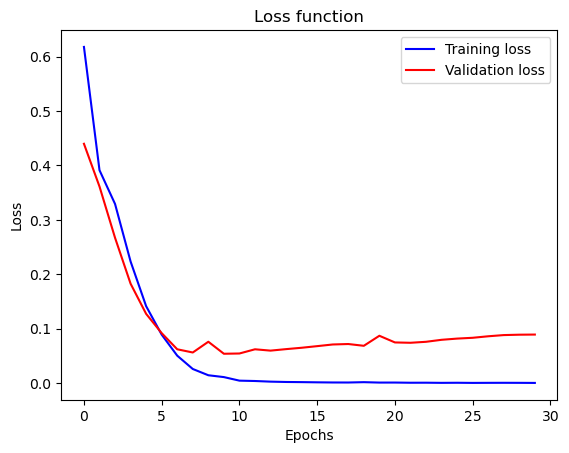

In [28]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label="Training loss")
plt.plot(history.history["val_loss"], color="r", label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss function")
plt.legend()
plt.show()

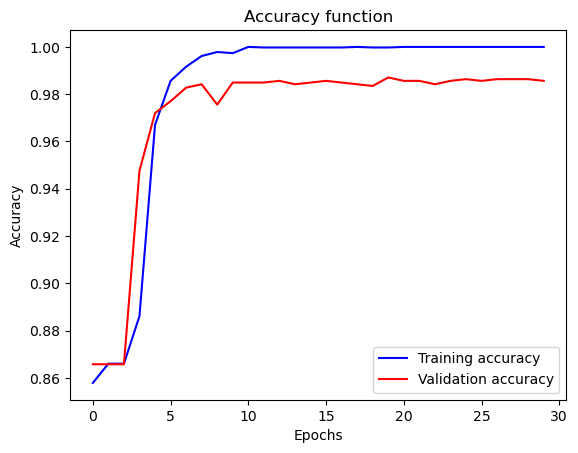

In [29]:
# Visualization of the training process on the metric function 
plt.plot(history.history["accuracy"], color="b", label="Training accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy function")
plt.legend()
plt.show()

In [30]:
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

Precision: 97.18%
Recall: 91.98%
F1 Score: 94.51%


In [31]:
init_weights = model.get_weights()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

model.set_weights(init_weights)

history = model.fit(train_batch,
                    epochs=40,
                    callbacks=[monitor],
                    validation_data=val_batch,
                    verbose=1)

Epoch 1/40


9/9 [==============================] - 2s 220ms/step - loss: 3.6223e-04 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 0.9856
Epoch 2/40
9/9 [==============================] - 2s 232ms/step - loss: 2.9954e-04 - accuracy: 1.0000 - val_loss: 0.0914 - val_accuracy: 0.9856
Epoch 3/40
9/9 [==============================] - 2s 232ms/step - loss: 3.3847e-04 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9856
Epoch 4/40
9/9 [==============================] - 2s 238ms/step - loss: 2.6803e-04 - accuracy: 1.0000 - val_loss: 0.0935 - val_accuracy: 0.9856
Epoch 5/40
9/9 [==============================] - 2s 227ms/step - loss: 2.9258e-04 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9864
Epoch 6/40
9/9 [==============================] - 2s 238ms/step - loss: 2.4623e-04 - accuracy: 1.0000 - val_loss: 0.0964 - val_accuracy: 0.9864
Epoch 6: early stopping


In [32]:
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

Precision: 97.18%
Recall: 91.98%
F1 Score: 94.51%


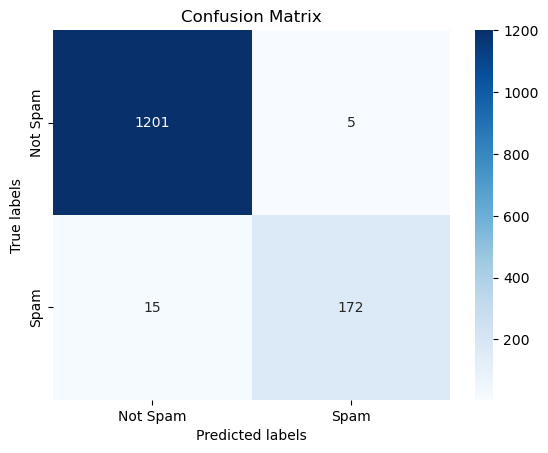

In [33]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

# Part 4: Transfer Learning

## Preparing the cleaned data:

In [34]:
# Train Test Split
X_train, X_val, Y_train, Y_val = train_test_split(spam_data.text_cleaned,spam_data.label, test_size=0.25, random_state=42, stratify=spam_data.label)

In [35]:
X_train.shape, X_val.shape

((4179,), (1393,))

In [36]:
train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

## Building our batch training and validation datasets:

In [37]:
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)

## Selecting a pretrained text embedding model from tf hub:

## The preprocessing model:

In [38]:
base_model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
hub_layer = hub.KerasLayer(base_model, output_shape=[50], input_shape=[], 
                           dtype=tf.string, trainable=True, name="embedding")
embedding = tf.keras.Sequential()
embedding.add(hub_layer)
embedding.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (KerasLayer)      (None, 50)                48190600  
                                                                 
Total params: 48,190,600
Trainable params: 48,190,600
Non-trainable params: 0
_________________________________________________________________


In [39]:
model = embedding
# Expanding the dimension of the input to fit the embedding layer
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)))
#Addding Bi-directional LSTM
model.add(Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
#Deep Learninng models can be overfit easily, to avoid this, we add randomization using drop out
model.add(Dropout(0.1))
#Adding sigmoid activation function to normalize the output
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (KerasLayer)      (None, 50)                48190600  
                                                                 
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           183296    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 16)               

## Compiling the model:

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
init_weights = model.get_weights()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (KerasLayer)      (None, 50)                48190600  
                                                                 
 lambda (Lambda)             (None, 1, 50)             0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           183296    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            


                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,543,193
Trainable params: 48,543,193
Non-trainable params: 0
_________________________________________________________________
None


## Training the model:

In [42]:
history = model.fit(train_batch, 
                    epochs=30, 
                     validation_data=val_batch)

Epoch 1/30
9/9 [==============================] - 5s 269ms/step - loss: 0.6691 - accuracy: 0.8416 - val_loss: 0.6197 - val_accuracy: 0.8658
Epoch 2/30
9/9 [==============================] - 2s 171ms/step - loss: 0.5580 - accuracy: 0.8660 - val_loss: 0.4398 - val_accuracy: 0.8658
Epoch 3/30
9/9 [==============================] - 2s 183ms/step - loss: 0.3655 - accuracy: 0.8660 - val_loss: 0.3026 - val_accuracy: 0.8658
Epoch 4/30
9/9 [==============================] - 2s 171ms/step - loss: 0.2658 - accuracy: 0.8660 - val_loss: 0.2371 - val_accuracy: 0.8658
Epoch 5/30
9/9 [==============================] - 1s 164ms/step - loss: 0.1941 - accuracy: 0.8768 - val_loss: 0.1957 - val_accuracy: 0.9304
Epoch 6/30
9/9 [==============================] - 1s 163ms/step - loss: 0.1569 - accuracy: 0.9543 - val_loss: 0.1707 - val_accuracy: 0.9591
Epoch 7/30
9/9 [==============================] - 2s 174ms/step - loss: 0.1261 - accuracy: 0.9816 - val_loss: 0.1487 - val_accuracy: 0.9691
Epoch 8/30
9/9 [====

In [43]:
Y_predict = [1 if o>0.5 else 0 for o in model.predict(X_val)]
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

44/44 [==============================] - 1s 22ms/step
Precision: 89.42%
Recall: 90.37%
F1 Score: 89.89%


In [44]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

model.set_weights(init_weights)

history = model.fit(train_batch,
                    epochs=100,
                    callbacks=[monitor],
                    validation_data=val_batch,
                    verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 180ms/step - loss: 0.6796 - accuracy: 0.8442 - val_loss: 0.6470 - val_accuracy: 0.8658
Epoch 2/100
9/9 [==============================] - 2s 176ms/step - loss: 0.6088 - accuracy: 0.8660 - val_loss: 0.5255 - val_accuracy: 0.8658
Epoch 3/100
9/9 [==============================] - 2s 183ms/step - loss: 0.4389 - accuracy: 0.8660 - val_loss: 0.3609 - val_accuracy: 0.8658
Epoch 4/100
9/9 [==============================] - 2s 177ms/step - loss: 0.3273 - accuracy: 0.8660 - val_loss: 0.2509 - val_accuracy: 0.8658
Epoch 5/100
9/9 [==============================] - 2s 174ms/step - loss: 0.2171 - accuracy: 0.8660 - val_loss: 0.1923 - val_accuracy: 0.8686
Epoch 6/100
9/9 [==============================] - 2s 173ms/step - loss: 0.1560 - accuracy: 0.9294 - val_loss: 0.1609 - val_accuracy: 0.9684
Epoch 7/100
9/9 [==============================] - 2s 172ms/step - loss: 0.1087 - accuracy: 0.9811 - val_loss: 0.1241 - val_accuracy: 0.9677
Epoch 8/100
9

In [45]:
Y_predict = [1 if o>0.5 else 0 for o in model.predict(X_val)]
cf_matrix =confusion_matrix(Y_val,Y_predict)
tn, fp, fn, tp = confusion_matrix(Y_val,Y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(Y_val, Y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(Y_val, Y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(Y_val,Y_predict)))

44/44 [==============================] - 1s 22ms/step
Precision: 89.12%
Recall: 91.98%
F1 Score: 90.53%


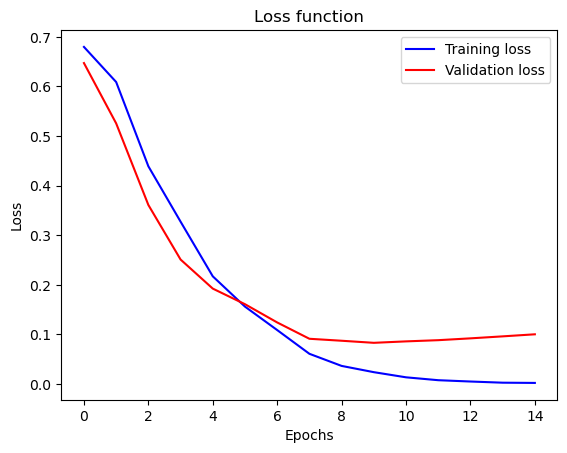

In [46]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label="Training loss")
plt.plot(history.history["val_loss"], color="r", label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss function")
plt.legend()
plt.show()

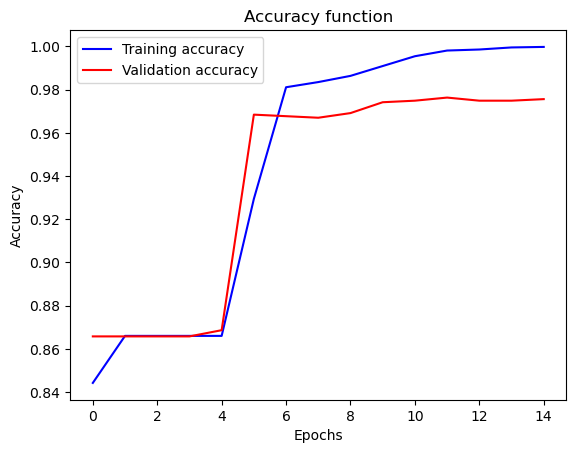

In [47]:
# Visualization of the training process on the metric function 
plt.plot(history.history["accuracy"], color="b", label="Training accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Accuracy function")
plt.legend()
plt.show()

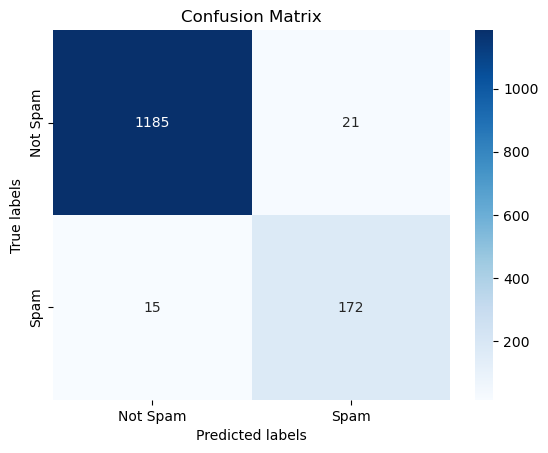

In [48]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

# Conclusion

For this project, we have trained two deep learning models in order to detect spams in text messages. This is a natural language processing based approach, where we take the texts, tokenize the words, embed them and train our model. We tested our own model architecture based on bidirectional LSTM, as well as a pretrained NLP model via transfer learning.

Surprisingly, our novel model outperformed the transfer learning based approach. It might be due to the fact, that larger models require more data to be efficient, as the architecture might be too complex.

Finally, by analysing the results of our trained model, it managed to detect spams quite efficiently. With an F1 score of 95%. However it is important to note that since we're working on spam detection, we should consider focusing on the Recall metric (92%) since we need to make sure that as many real emails as possible get through to the user, even if a couple of spams get through, instead of having important texts end up in the spam folder.